## imports

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from netCDF4 import Dataset, num2date
from sklearn.model_selection import KFold
import xgboost
from xgboost import XGBRegressor


LAND_DF_DIRECTORY = r'C:\Users\ydjoe\Documents\solar rad stats\land_data\Dublin_land_solar_radiation_{}.csv'

SAT_DF_DIRECTORY = r'C:\Users\ydjoe\Documents\solar rad stats\surface_solar_radiation_downwards\Dublin_sat_solar_radiation_{}.csv'

In [2]:
# Import basic modules
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

import seaborn as sns
from matplotlib import rcParams

# Import regression and error metrics modules
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Import plotly modules to view time series in a more interactive way
import plotly.graph_objects as go
import pandas as pd

# Standard scaler for preprocessing
from sklearn.preprocessing import StandardScaler

# Importing time series split for cross validation 
from sklearn.model_selection import TimeSeriesSplit

plt.style.use('bmh')

# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

#sns.set_style("whitegrid")
#sns.set_context("poster")


In [3]:
data_year = ['2014','2015','2016','2017','2018','2019','2020']
ls_land_dfs = []
ls_sat_dfs = []

for i in data_year:  
    df_land = pd.read_csv(LAND_DF_DIRECTORY.format(i),index_col = 0)
    sat_df = pd.read_csv(SAT_DF_DIRECTORY.format(i),index_col = 0)
    df_land = df_land.rename(columns={'[W/m2]': 'Val'})    
    sat_solar_rad = sat_df['Val'].to_list()
    land_solar_rad = df_land['Val'].to_list()

    ls_init_vals = [sat_solar_rad,land_solar_rad]
    ls_init_dfs = [sat_df,df_land]
    ls_dfs = []
    ls_final_vals = []

    for j in range(2):

        new_df = ls_init_dfs[j].copy()
        new_df['solar_diff'] = ls_init_vals[j]
        new_df = new_df.drop(new_df.columns[4],axis=1)

        solar_diff_hour_df = new_df[new_df.Hour==12]
        solar_diff_hour_df = solar_diff_hour_df.drop(solar_diff_hour_df.columns[3],axis=1)
        solar_diff_hour_df.reset_index(drop=True, inplace=True)

        solar_diff_mean_lst = new_df.groupby(['Month','Day'])['solar_diff'].mean().to_list()
        solar_diff_hour_df['solar_diff'] = solar_diff_mean_lst

        ls_dfs.append(solar_diff_hour_df)

    ls_sat_dfs.append(ls_dfs[0])
    ls_land_dfs.append(ls_dfs[1])
    

df_land_daily = pd.concat(ls_land_dfs)
df_sat_daily = pd.concat(ls_sat_dfs)
df_land_daily = df_land_daily.rename(columns={'solar_diff': 'Val'})
df_sat_daily = df_sat_daily.rename(columns={'solar_diff': 'Val'})



In [4]:
data_year = ['2014','2015','2016','2017','2018','2019','2020']
ls_land_dfs = []
ls_sat_dfs = []

for i in data_year:  
    df_land = pd.read_csv(LAND_DF_DIRECTORY.format(i),index_col = 0)
    sat_df = pd.read_csv(SAT_DF_DIRECTORY.format(i),index_col = 0)
    df_land = df_land.rename(columns={'[W/m2]': 'Val'})    

    ls_sat_dfs.append(sat_df)
    ls_land_dfs.append(df_land)
    

df_land_hourly = pd.concat(ls_land_dfs)
df_sat_hourly = pd.concat(ls_sat_dfs)
df_land_hourly = df_land_hourly.rename(columns={'solar_diff': 'Val'})
df_sat_hourly = df_sat_hourly.rename(columns={'solar_diff': 'Val'})
df_sat_hourly['Val'] = df_sat_hourly['Val'].shift(-2)
df_sat_hourly = df_sat_hourly.fillna(0)

In [5]:
df_hourly = df_sat_hourly.copy()
df_hourly['Tval'] = df_land_hourly['Val']

In [6]:
print(df_sat_hourly.shape)
print(df_land_hourly.shape)
print(df_hourly.shape)

(61368, 5)
(61368, 5)
(61368, 6)


In [7]:
df_hourly.head()

,Year,Month,Day,Hour,Val,Tval
0,2014,1,1,0,0.0,0
1,2014,1,1,1,0.0,0
2,2014,1,1,2,0.0,0
3,2014,1,1,3,0.0,0
4,2014,1,1,4,0.0,0


In [8]:
hours = df_hourly.Hour.unique()
months = df_hourly.Month.unique()

c = 0
a_x = {}
for j in months:
    ar_x = []
    ar_y = []
    a_y = []
    for i in range(len(hours)):
        ar_x.append(hours[i])
        df_mon_hr = df_hourly.loc[(df_hourly.Hour==i) & (df_hourly.Month==j)]
        y_val = len(df_mon_hr.loc[df_mon_hr.Val!=0])/len(df_mon_hr)*100
        if y_val!=100:
            a_y.append(i)
            c+=1

    a_x[j] = a_y

print(c)

df = df_hourly.copy()

for i in a_x.keys():
    del_hours = a_x[i] 
    idx_to_del = df[(df.Month==i)][df[(df.Month==i)]['Hour'].isin(del_hours)].index.to_list()
    df = df.drop(idx_to_del)


154


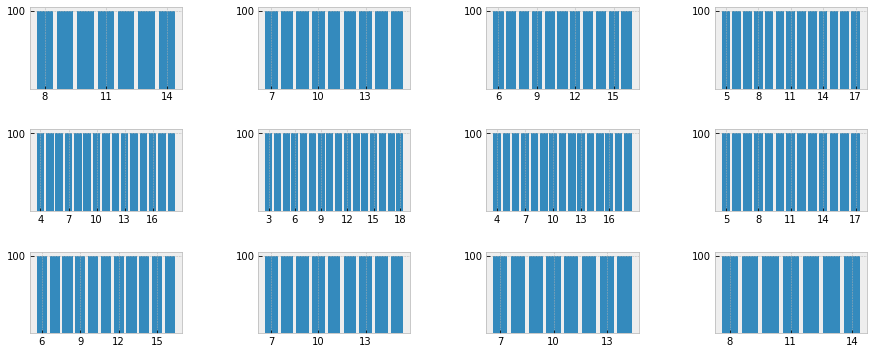

In [9]:
hours = df.Hour.unique()
months = df.Month.unique()

fig, axs = plt.subplots(3,4, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
c = 0
for j in months:
    ar_x = []
    ar_y = []
    hours = df[df.Month==j]['Hour'].unique()
    for i in hours:
        ar_x.append(i)
        df_mon_hr = df.loc[(df.Hour==i) & (df.Month==j)]
        try:
            y_val = len(df_mon_hr.loc[df_mon_hr.Val!=0])/len(df_mon_hr)*100
        except:
            ar_y.append(y_val)
            continue
        ar_y.append(y_val)
    

    axs[c].set_xticks(np.arange(min(ar_x), max(ar_x)+1, 3.0))
    axs[c].set_yticks(np.arange(min(ar_y), max(ar_y)+1, 30))
    axs[c].bar(ar_x,ar_y)   
    c+=1

In [11]:
df_category = df.copy()

# creating categorical columns for linear regression 
cat_cols = ['Year','Day', 'Hour']

for col in cat_cols:
    df_category[col] = df_category[col].astype('category')

df_category = pd.get_dummies(df_category, drop_first = True)

In [12]:
df_cat_hour = df.copy()

# creating categorical columns for linear regression 
cat_cols = ['Hour','Month']

for col in cat_cols:
    df_cat_hour[col] = df_cat_hour[col].astype('category')

df_cat_hour = pd.get_dummies(df_cat_hour, drop_first = True)

In [13]:
df.shape

(28518, 6)

## Model 1

## define Functions

In [14]:
def train_test(data, test_size = 0.15, scale = False, cols_to_transform=None, include_test_scale=False):


    df = data.copy()
    # get the index after which test set starts
    test_index = int(len(df)*(1-test_size))
    
    # StandardScaler fit on the entire dataset
    if scale and include_test_scale:
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    X_train = df.drop('Tval', axis = 1).iloc[:test_index]
    y_train = df.Tval.iloc[:test_index]
    X_test = df.drop('Tval', axis = 1).iloc[test_index:]
    y_test = df.Tval.iloc[test_index:]
    
    # StandardScaler fit only on the training set
    if scale and not include_test_scale:
        scaler = StandardScaler()
        X_train[cols_to_transform] = scaler.fit_transform(X_train[cols_to_transform])
        X_test[cols_to_transform] = scaler.transform(X_test[cols_to_transform])
    
    return X_train, X_test, y_train, y_test

In [15]:
dict_error = {}

In [16]:
def error_metrics(y_pred, y_truth, model_name = None, test = True):


    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()
        
    print('\nError metrics for model {}'.format(model_name))
    
    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))
    print("RMSE or Root mean squared error: %.2f" % RMSE)
    
    # Explained variance score: 1 is perfect prediction

    R2 = r2_score(y_truth, y_pred)
    print('Variance score: %.2f' % R2 )

    MAE = mean_absolute_error(y_truth, y_pred)
    print('Mean Absolute Error: %.2f' % MAE)

    MAPE = (np.mean(np.abs((y_truth - y_pred) / y_truth)) * 100)
    print('Mean Absolute Percentage Error: %.2f %%' % MAPE)
    
    # Appending the error values along with the model_name to the dict
    if test:
        train_test = 'test'
    else:
        train_test = 'train'
    
    #df = pd.DataFrame({'model': model_name, 'RMSE':RMSE, 'R2':R2, 'MAE':MAE, 'MAPE':MAPE}, index=[0])
    name_error = ['model', 'train_test', 'RMSE', 'R2', 'MAE', 'MAPE']
    value_error = [model_name, train_test, RMSE, R2, MAE, MAPE]
    list_error = list(zip(name_error, value_error))
    
    for error in list_error:
        if error[0] in dict_error:
            # append the new number to the existing array at this slot
            dict_error[error[0]].append(error[1])
        else:
            # create a new array in this slot
            dict_error[error[0]] = [error[1]]
    #return(dict_error)

In [17]:
def plot_predvstrue_reg(pred, truth, model_name=None):
    
    min_1 = min(pred)
    max_1 = max(pred)
    min_2 = min(truth)
    max_2 = max(truth)
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    ax.scatter(truth, pred) 
    _ = plt.xlabel("Satellite based GHI in W/m2")
    _ = plt.ylabel("Land based GHI in W/m2")
    _ = plt.title("Observed vs Predicted energy using model {}".format(model_name))
    _ = plt.xlim(-50, max_2)
    _ = plt.ylim(-50, max_1)
    #plotting 45 deg line to see how the prediction differs from the observed values
    x = np.linspace(*ax.get_xlim())
    _ = ax.plot(x, x)

In [18]:
df_category = df.copy()

# creating categorical columns for linear regression 
cat_cols = ['Year','Day', 'Hour','Month']

for col in cat_cols:
    df_category[col] = df_category[col].astype('category')

df_category = pd.get_dummies(df_category, drop_first = True)

In [19]:
df_selective = df.copy()

# creating categorical columns for linear regression 
cat_cols = ['Year', 'Hour','Month']

for col in cat_cols:
    df_selective[col] = df_selective[col].astype('category')

df_selective = pd.get_dummies(df_selective, drop_first = True)

## Simple Linear Regression

In [20]:
cols_to_transform = []
X_train, X_test, y_train, y_test = train_test(df_selective, test_size = 0.15, scale = False, cols_to_transform=cols_to_transform)

In [21]:
lm = LinearRegression()
lm

LinearRegression()

In [22]:
lm.fit(X_train, y_train)

LinearRegression()

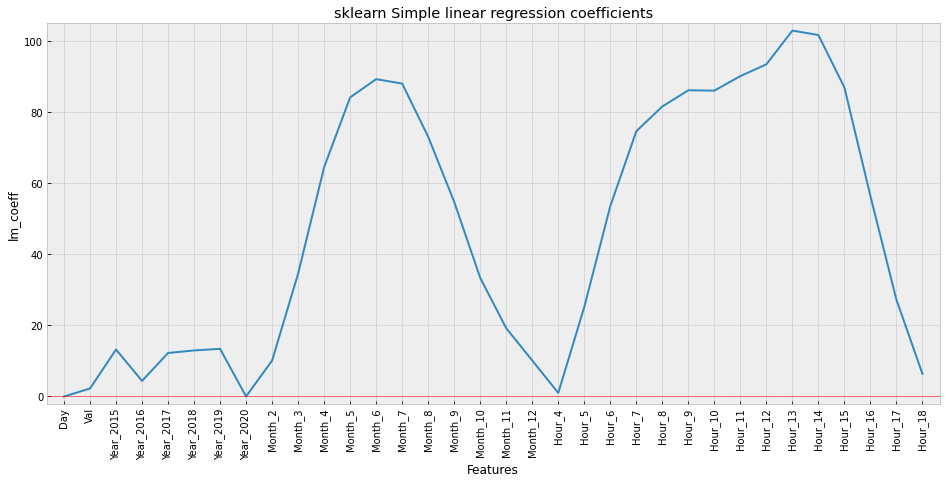

In [23]:
_ = plt.figure(figsize = (16, 7))
_ = plt.plot(range(len(X_train.columns)), lm.coef_)
_ = plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)
_ = plt.margins(0.02)
_ = plt.axhline(0, linewidth = 0.5, color = 'r')
_ = plt.title('sklearn Simple linear regression coefficients')
_ = plt.ylabel('lm_coeff')
_ = plt.xlabel('Features')

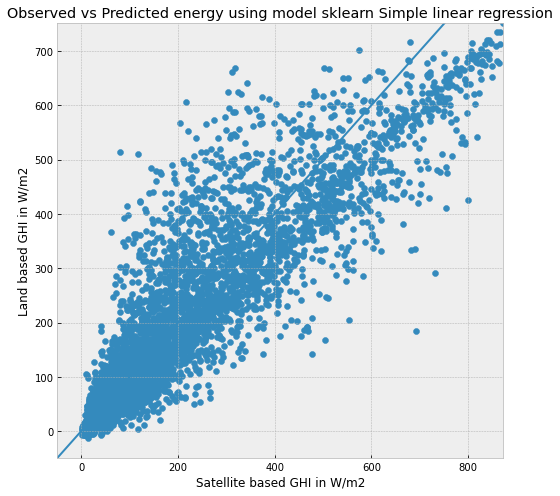

In [24]:
lm.fit(X_train, y_train)
plot_predvstrue_reg(lm.predict(X_test), y_test, model_name = 'sklearn Simple linear regression')

In [25]:
error_metrics(lm.predict(X_train), y_train, model_name = 'Simple linear regression With Reduced Features', test = False)
error_metrics(lm.predict(X_test), y_test, model_name = 'Simple linear regression With Reduced Features', test = True)


Error metrics for model Simple linear regression With Reduced Features
RMSE or Root mean squared error: 87.64
Variance score: 0.80
Mean Absolute Error: 62.12
Mean Absolute Percentage Error: 39.99 %

Error metrics for model Simple linear regression With Reduced Features
RMSE or Root mean squared error: 89.68
Variance score: 0.78
Mean Absolute Error: 63.66
Mean Absolute Percentage Error: 38.73 %


In [26]:
dict_error

{'model': ['Simple linear regression With Reduced Features',
  'Simple linear regression With Reduced Features'],
 'train_test': ['train', 'test'],
 'RMSE': [87.64279757118733, 89.67965952357677],
 'R2': [0.7986119831557974, 0.7844573025847155],
 'MAE': [62.11519546382772, 63.66082008800347],
 'MAPE': [39.98654666594866, 38.72831725461709]}

## Ridge Regression

In [27]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha = 0.2, normalize = True)
ridge.fit(X_train, y_train)
ridge_coef = ridge.coef_

c:\Users\ydjoe\anaconda3\envs\geom_env\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


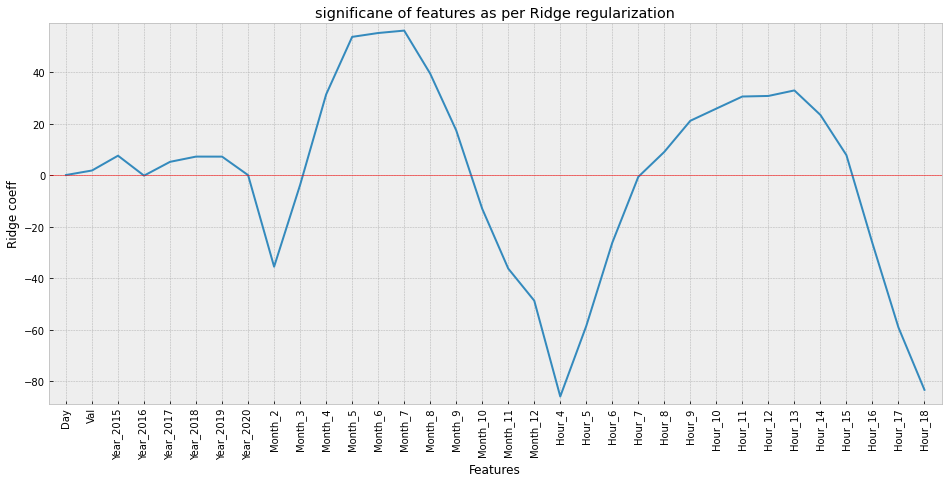

In [28]:
_ = plt.figure(figsize = (16, 7))
_ = plt.plot(range(len(X_train.columns)), ridge_coef)
_ = plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)
_ = plt.margins(0.02)
_ = plt.axhline(0, linewidth = 0.5, color = 'r')
_ = plt.title('significane of features as per Ridge regularization')
_ = plt.ylabel('Ridge coeff')
_ = plt.xlabel('Features')

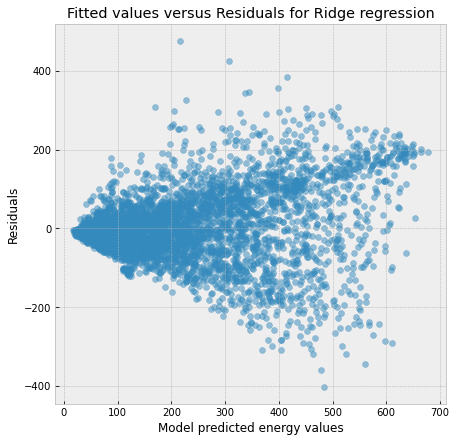

In [29]:
residuals = (y_test - ridge.predict(X_test))
_ = plt.figure(figsize=(7,7))
_ = plt.scatter(ridge.predict(X_test) , residuals, alpha = 0.5) 
_ = plt.xlabel("Model predicted energy values")
_ = plt.ylabel("Residuals")
_ = plt.title("Fitted values versus Residuals for Ridge regression")

In [30]:
print('Ridge regression on training set')
error_metrics(ridge.predict(X_train), y_train, model_name = 'Ridge regression With Reduced Features', test = False)
print('\nRidge regression on test set')
error_metrics(ridge.predict(X_test), y_test, model_name = 'Ridge regression With Reduced Features', test = True)

Ridge regression on training set

Error metrics for model Ridge regression With Reduced Features
RMSE or Root mean squared error: 92.12
Variance score: 0.78
Mean Absolute Error: 68.78
Mean Absolute Percentage Error: 62.92 %

Ridge regression on test set

Error metrics for model Ridge regression With Reduced Features
RMSE or Root mean squared error: 91.56
Variance score: 0.78
Mean Absolute Error: 66.05
Mean Absolute Percentage Error: 58.73 %


## Elastic net regression

In [32]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

def trend_model(data, cols_to_transform, l1_space, alpha_space, cols_use = 0, scale = False, test_size = 0.15, 
                include_test_scale=False):

    if cols_use != 0:
        df = data[cols_use]
    else:
        df = data
    
    X_train, X_test, y_train, y_test = train_test(df, test_size = test_size, 
                                              scale = scale, cols_to_transform=cols_to_transform, 
                                              include_test_scale=include_test_scale)

    param_grid = {'l1_ratio': l1_space, 'alpha': alpha_space}
    elastic_net = ElasticNet()
    tscv = TimeSeriesSplit(n_splits=5)

    gm_cv = GridSearchCV(elastic_net, param_grid, cv = tscv)
    gm_cv.fit(X_train, y_train)

    y_pred = gm_cv.predict(X_test)
    r2 = gm_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
    print("Tuned ElasticNet R squared: {}".format(r2))
    print("Tuned ElasticNet RMSE: {}".format(np.sqrt(mse)))

    elastic_net_opt = ElasticNet(l1_ratio = gm_cv.best_params_['l1_ratio']) 
    elastic_net_opt.fit(X_train, y_train)
    
    
    _ = plt.figure(figsize = (15, 7))
    _ = plt.plot(range(len(X_train.columns)), elastic_net_opt.coef_)
    _ = plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)
    _ = plt.margins(0.02)
    _ = plt.axhline(0, linewidth = 0.5, color = 'r')
    _ = plt.title('significane of features as per Elastic regularization')
    _ = plt.ylabel('Elastic net coeff')
    _ = plt.xlabel('Features')
    
    
    _ = plt.figure(figsize = (5,5))
    _ = plot_predvstrue_reg(elastic_net_opt.predict(X_test), y_test, model_name = 'Elastic net optimal linear regression')
    

    return X_train, X_test, y_train, y_test, elastic_net_opt

In [33]:
data = df_selective
cols_to_transform = []
l1_space = np.linspace(0, 1, 30)
alpha_space = np.logspace(-2, 0, 30)

Tuned ElasticNet l1 ratio: {'alpha': 0.01, 'l1_ratio': 1.0}
Tuned ElasticNet R squared: 0.7848267763020932
Tuned ElasticNet RMSE: 89.6027641124022


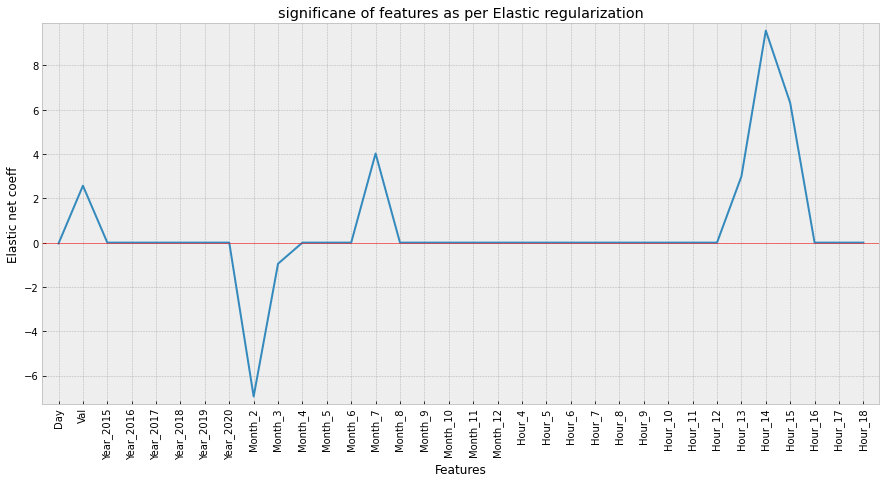

<Figure size 360x360 with 0 Axes>

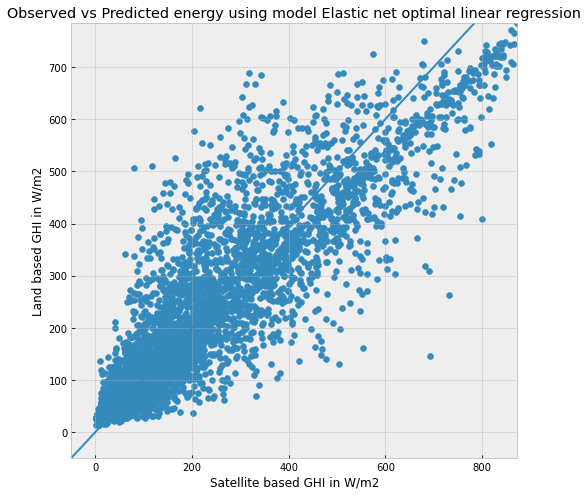

In [34]:
import warnings  
warnings.filterwarnings('ignore')
X_train, X_test, y_train, y_test, elastic_net_opt = trend_model(data=data, cols_to_transform=cols_to_transform, 
                                                                l1_space=l1_space, alpha_space=alpha_space,
                                                                scale = False, test_size = 0.15, include_test_scale=False)

In [35]:
print('Elastic net regression on training set')
error_metrics(elastic_net_opt.predict(X_train), y_train, model_name = 'Tuned elastic net regression With Reduced Features', 
              test = False)

print('\nElastic net regression on test set')
error_metrics(elastic_net_opt.predict(X_test), y_test, model_name = 'Tuned elastic net regression With Reduced Features', 
              test = True)

Elastic net regression on training set

Error metrics for model Tuned elastic net regression With Reduced Features
RMSE or Root mean squared error: 89.98
Variance score: 0.79
Mean Absolute Error: 63.70
Mean Absolute Percentage Error: 45.67 %

Elastic net regression on test set

Error metrics for model Tuned elastic net regression With Reduced Features
RMSE or Root mean squared error: 90.91
Variance score: 0.78
Mean Absolute Error: 63.01
Mean Absolute Percentage Error: 44.42 %


## RF

In [36]:
n_estimators = [int(x) for x in np.linspace(10, 200, 10, endpoint=True)]
max_features = ['auto', 'sqrt']
max_depth = list(range(1,6))

random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth':max_depth}
print(random_grid)

{'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 2, 3, 4, 5]}


In [37]:
from sklearn.model_selection import RandomizedSearchCV


rf = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               cv = tscv, verbose=2, random_state = 42, n_jobs = -1)


rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 73, 'max_features': 'auto', 'max_depth': 5}

In [38]:
rf_random.score(X_train, y_train)

0.7924029723474438

In [39]:
rf_random.score(X_test, y_test) 

0.7808893059996426

In [40]:
print('Tuned Random forest errors on training set')
error_metrics(rf_random.predict(X_train), y_train, model_name = 'Tuned Random forest With Reduced Features', test = False)
print('\nTuned Random forest errors on test set')
error_metrics(rf_random.predict(X_test), y_test, model_name = 'Tuned Random forest With Reduced Features', test = True)

Tuned Random forest errors on training set

Error metrics for model Tuned Random forest With Reduced Features
RMSE or Root mean squared error: 88.98
Variance score: 0.79
Mean Absolute Error: 63.11
Mean Absolute Percentage Error: 46.46 %

Tuned Random forest errors on test set

Error metrics for model Tuned Random forest With Reduced Features
RMSE or Root mean squared error: 90.42
Variance score: 0.78
Mean Absolute Error: 62.75
Mean Absolute Percentage Error: 44.94 %


## Lag data

In [41]:
df_lag = df.copy()

for i in range(6):
    df_lag['lag'+str(i+1)] = df_lag['Tval'].shift(i+1)

In [42]:
df_lag = df_lag.dropna()

In [43]:
cols_to_transform = []

list_lags = ['lag'+str(i+1) for i in range(6)]
cols_to_transform.extend(list_lags)

X_train_lag, X_test_lag, y_train_lag, y_test_lag = train_test(df_lag, \
                                                              test_size = 0.15, scale = True, \
                                                              cols_to_transform=cols_to_transform)

### Elastic Net Regression

In [44]:
elastic_net_lag = ElasticNet(l1_ratio = 1, alpha=0.2)
elastic_net_lag.fit(X_train_lag, y_train_lag)

ElasticNet(alpha=0.2, l1_ratio=1)

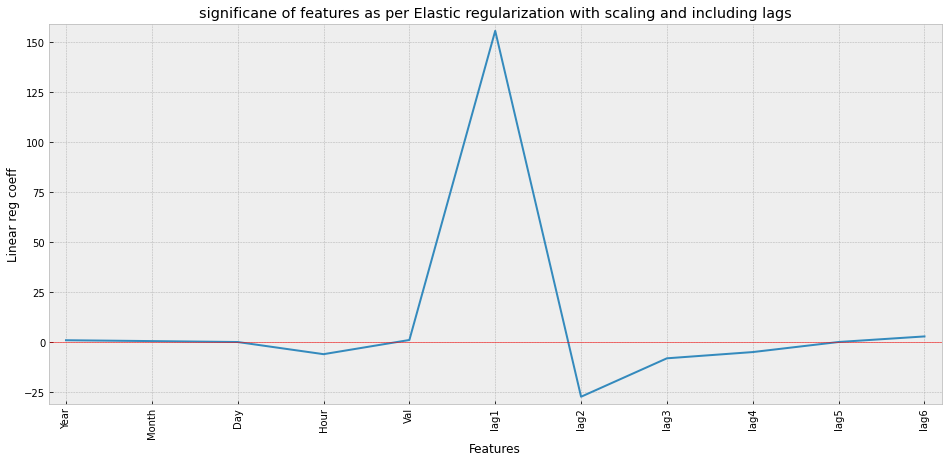

In [45]:
_ = plt.figure(figsize = (16, 7))
_ = plt.plot(range(len(X_train_lag.columns)), elastic_net_lag.coef_)
_ = plt.xticks(range(len(X_train_lag.columns)), X_train_lag.columns.values, rotation = 90)
_ = plt.margins(0.02)
_ = plt.axhline(0, linewidth = 0.5, color = 'r')
_ = plt.title('significane of features as per Elastic regularization with scaling and including lags')
_ = plt.ylabel('Linear reg coeff')
_ = plt.xlabel('Features')

In [46]:
print('\nElastic net errors with lags on train')
error_metrics(elastic_net_lag.predict(X_train_lag), y_train_lag, model_name = 'Elastic net with all lags', test=False)
print('\nElastic net errors with lags on test')
error_metrics(elastic_net_lag.predict(X_test_lag), y_test_lag, model_name = 'Elastic net with all lags', test=True)


Elastic net errors with lags on train

Error metrics for model Elastic net with all lags
RMSE or Root mean squared error: 64.96
Variance score: 0.89
Mean Absolute Error: 46.45
Mean Absolute Percentage Error: 44.08 %

Elastic net errors with lags on test

Error metrics for model Elastic net with all lags
RMSE or Root mean squared error: 61.48
Variance score: 0.90
Mean Absolute Error: 43.99
Mean Absolute Percentage Error: 46.98 %


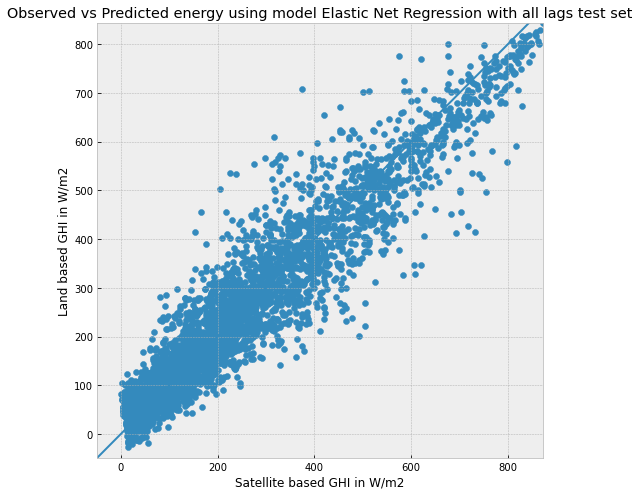

In [47]:
plot_predvstrue_reg(elastic_net_lag.predict(X_test_lag), y_test_lag, 
                    model_name = 'Elastic Net Regression with all lags test set')

### Random Forest Regression

In [48]:
rf = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)

rflag = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               cv = tscv, verbose=2, random_state = 42, n_jobs = -1)

rflag.fit(X_train_lag, y_train_lag)

rflag.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 73, 'max_features': 'auto', 'max_depth': 5}

In [49]:
print('Random forest errors with lags on training')
error_metrics(rflag.predict(X_train_lag), y_train_lag, model_name = 'Random forest with all lags', test=False)
print('\nRandom forest errors with lags on test')
error_metrics(rflag.predict(X_test_lag), y_test_lag, model_name = 'Random forest with all lags', test=True)

Random forest errors with lags on training

Error metrics for model Random forest with all lags
RMSE or Root mean squared error: 67.02
Variance score: 0.88
Mean Absolute Error: 48.11
Mean Absolute Percentage Error: 37.62 %

Random forest errors with lags on test

Error metrics for model Random forest with all lags
RMSE or Root mean squared error: 64.51
Variance score: 0.89
Mean Absolute Error: 46.15
Mean Absolute Percentage Error: 36.68 %


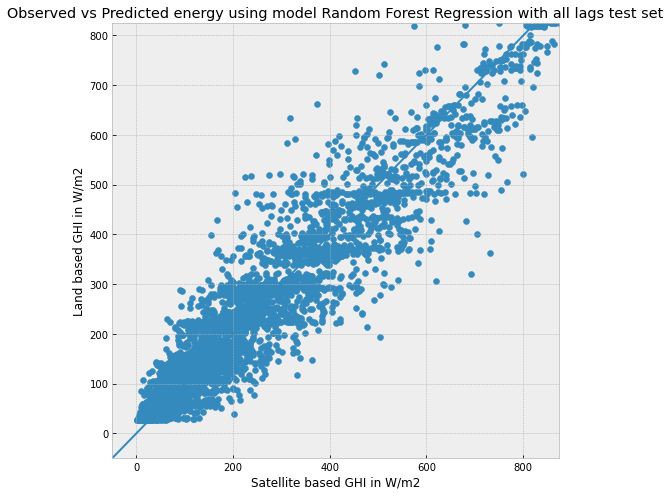

In [50]:
plot_predvstrue_reg(rflag.predict(X_test_lag), y_test_lag, 
                    model_name = 'Random Forest Regression with all lags test set')

### Simple Linear Regression

In [51]:
lm = LinearRegression()
lm.fit(X_train_lag, y_train_lag)

error_metrics(lm.predict(X_train_lag), y_train_lag, model_name = 'Simple linear regression With lags', test = False)
error_metrics(lm.predict(X_test_lag), y_test_lag, model_name = 'Simple linear regression With lags', test = True)


Error metrics for model Simple linear regression With lags
RMSE or Root mean squared error: 64.95
Variance score: 0.89
Mean Absolute Error: 46.39
Mean Absolute Percentage Error: 43.84 %

Error metrics for model Simple linear regression With lags
RMSE or Root mean squared error: 61.40
Variance score: 0.90
Mean Absolute Error: 43.89
Mean Absolute Percentage Error: 46.84 %


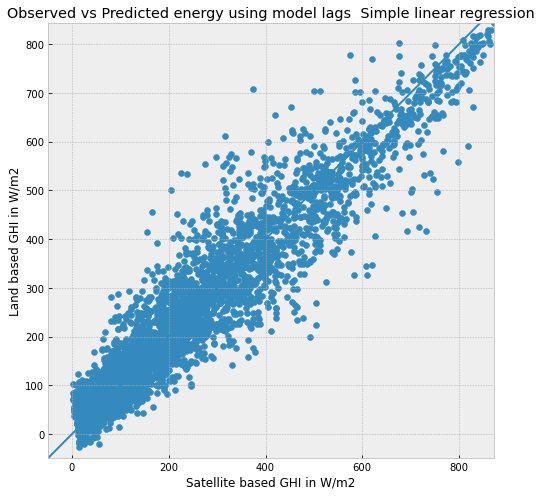

In [52]:
plot_predvstrue_reg(lm.predict(X_test_lag), y_test_lag, model_name = 'lags  Simple linear regression')

### Xgboost

In [53]:
import xgboost as xgb

In [54]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 3, alpha = 5, n_estimators = 100, random_state=42)

In [55]:
xg_reg.fit(X_train_lag, y_train_lag)

[02:39:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=42, reg_alpha=5, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [56]:
preds_boost = xg_reg.predict(X_test_lag)

In [57]:
_ = error_metrics(preds_boost, y_test_lag, model_name='XGBoost with lags', test=True)
_ = error_metrics(xg_reg.predict(X_train_lag), y_train_lag, model_name='XGBoost with lags', test= False)


Error metrics for model XGBoost with lags
RMSE or Root mean squared error: 62.37
Variance score: 0.90
Mean Absolute Error: 44.09
Mean Absolute Percentage Error: 36.19 %

Error metrics for model XGBoost with lags
RMSE or Root mean squared error: 63.75
Variance score: 0.89
Mean Absolute Error: 45.23
Mean Absolute Percentage Error: 35.17 %


### Ridge Regression

In [58]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha = 0.2, normalize = True)
ridge.fit(X_train_lag, y_train_lag)

print('Ridge regression on training set')
error_metrics(ridge.predict(X_train_lag), y_train_lag, model_name = 'Ridge regression With lags', test = False)

print('\nRidge regression on test set')
error_metrics(ridge.predict(X_test_lag), y_test_lag, model_name = 'Ridge regression With lags', test = True)

Ridge regression on training set

Error metrics for model Ridge regression With lags
RMSE or Root mean squared error: 71.41
Variance score: 0.87
Mean Absolute Error: 53.63
Mean Absolute Percentage Error: 57.41 %

Ridge regression on test set

Error metrics for model Ridge regression With lags
RMSE or Root mean squared error: 69.31
Variance score: 0.87
Mean Absolute Error: 52.59
Mean Absolute Percentage Error: 62.87 %


# Fourier Terms

In [61]:
df_ts = df.copy()

In [62]:
df_ts = df.copy()
df_ts['Date'] = pd.to_datetime(df_ts[["Year", "Month", "Day","Hour"]])
df_ts.reset_index(drop=True, inplace=True)

In [63]:
df_ts.index = df_ts.Date
df_ts.drop('Date',inplace=True,axis=1)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def add_fourier_terms(df, year_k, week_k, day_k):

    for k in range(1, year_k+1):
        # year has a period of 365.25 including the leap year
        df['year_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofyear/365.25) 
        df['year_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofyear/365.25)

    for k in range(1, week_k+1):
        
        # week has a period of 7
        df['week_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofweek/7)
        df['week_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofweek/7)


    for k in range(1, day_k+1):
        
        # day has period of 24
        df['hour_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.hour/24)
        df['hour_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.hour/24) 

In [66]:
warnings.filterwarnings('ignore')
add_fourier_terms(df_ts, year_k= 5, week_k=5 , day_k=5)

In [68]:
import warnings
warnings.filterwarnings('ignore')


def add_fourier_terms(df, year_k, month_k, day_k):

    
    for k in range(1, year_k+1):
        # year has a period of 365.25 including the leap year
        df['year_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofyear/365.25) 
        df['year_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofyear/365.25)

    for k in range(1, month_k+1):
        
        # week has a period of 7
        df['month_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.month/30)
        df['month_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.month/30)


    for k in range(1, day_k+1):
        
        # day has period of 24
        df['hour_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.hour/24)
        df['hour_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.hour/24) 

In [69]:
warnings.filterwarnings('ignore')
add_fourier_terms(df_ts, year_k= 5, month_k=5 , day_k=5)

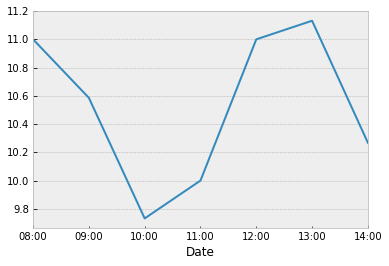

In [70]:
# Visualizing the new variables on hour seasonality
pd.plotting.register_matplotlib_converters()
_ = (1-df_ts.loc['01-02-2014':'01-02-2014', [col for col in df_ts if col.startswith('hour')]]).sum(axis = 1).plot()

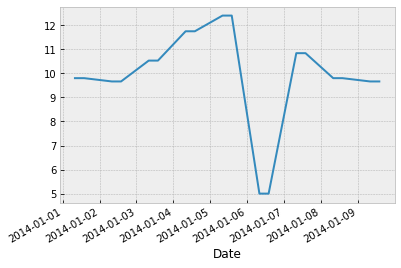

In [71]:
# Visualizing the new variables on week seasonality
_ = (1-df_ts.loc['01-01-2014':'01-09-2014', [col for col in df_ts if col.startswith('week')]]).sum(axis = 1).plot()

In [72]:
df_ts.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Val', 'Tval', 'year_sin1', 'year_cos1',
       'year_sin2', 'year_cos2', 'year_sin3', 'year_cos3', 'year_sin4',
       'year_cos4', 'year_sin5', 'year_cos5', 'week_sin1', 'week_cos1',
       'week_sin2', 'week_cos2', 'week_sin3', 'week_cos3', 'week_sin4',
       'week_cos4', 'week_sin5', 'week_cos5', 'hour_sin1', 'hour_cos1',
       'hour_sin2', 'hour_cos2', 'hour_sin3', 'hour_cos3', 'hour_sin4',
       'hour_cos4', 'hour_sin5', 'hour_cos5', 'month_sin1', 'month_cos1',
       'month_sin2', 'month_cos2', 'month_sin3', 'month_cos3', 'month_sin4',
       'month_cos4', 'month_sin5', 'month_cos5'],
      dtype='object')

In [73]:
sdgecyc = df_ts.drop([col for col in df_ts if 
                         col.startswith('time') or col.startswith('season') or col.startswith('lag')], axis=1)

In [74]:
X_train_fourier, X_test_fourier, y_train_fourier, y_test_fourier = train_test(sdgecyc, \
                                                              test_size = 0.15, )

### Simple Linear Regression

In [75]:
lm = LinearRegression()
lm.fit(X_train_fourier, y_train_fourier)

error_metrics(lm.predict(X_train_fourier), y_train_fourier, model_name = 'Simple linear regression With FT', test = False)
error_metrics(lm.predict(X_test_fourier), y_test_fourier, model_name = 'Simple linear regression With FT', test = True)


Error metrics for model Simple linear regression With FT
RMSE or Root mean squared error: 87.41
Variance score: 0.80
Mean Absolute Error: 61.99
Mean Absolute Percentage Error: 39.82 %

Error metrics for model Simple linear regression With FT
RMSE or Root mean squared error: 89.87
Variance score: 0.78
Mean Absolute Error: 62.83
Mean Absolute Percentage Error: 43.51 %


### Ridge Regression

In [76]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha = 0.2, normalize = True)
ridge.fit(X_train_fourier, y_train_fourier)

print('Ridge regression on training set')
error_metrics(ridge.predict(X_train_fourier), y_train_fourier, model_name = 'Ridge regression With fouriers', test = False)

print('\nRidge regression on test set')
error_metrics(ridge.predict(X_test_fourier), y_test_fourier, model_name = 'Ridge regression With fouriers', test = True)

Ridge regression on training set

Error metrics for model Ridge regression With fouriers
RMSE or Root mean squared error: 91.46
Variance score: 0.78
Mean Absolute Error: 67.78
Mean Absolute Percentage Error: 52.50 %

Ridge regression on test set

Error metrics for model Ridge regression With fouriers
RMSE or Root mean squared error: 92.72
Variance score: 0.77
Mean Absolute Error: 67.88
Mean Absolute Percentage Error: 56.51 %


### Elastic Net Regression

Tuned ElasticNet l1 ratio: {'alpha': 0.4520353656360243, 'l1_ratio': 1.0}
Tuned ElasticNet R squared: 0.7846128967849547
Tuned ElasticNet RMSE: 89.64728507025048


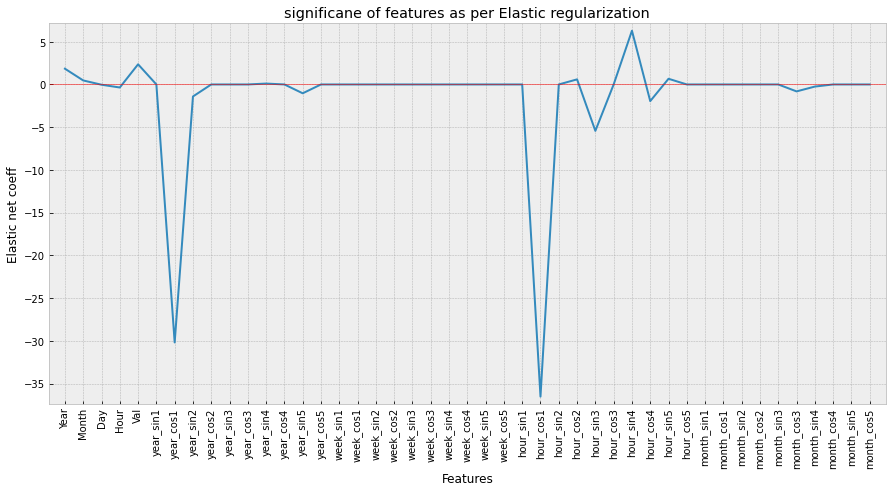

<Figure size 360x360 with 0 Axes>

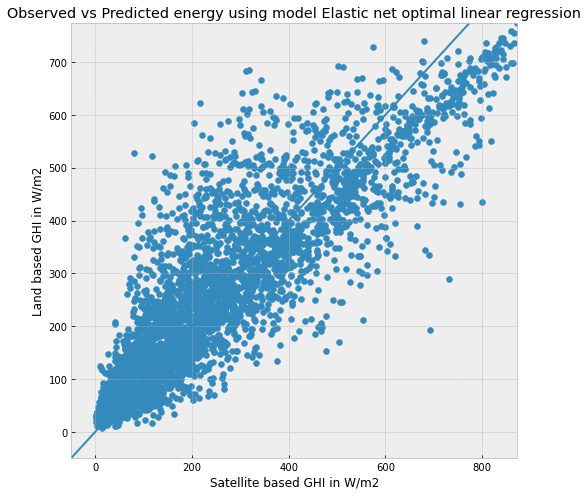

In [77]:
data = sdgecyc
cols_to_transform =[]
l1_space = np.linspace(0, 1, 30)
alpha_space = np.logspace(-2, 0, 30)

X_trainF, X_testF, y_trainF, y_testF, elastic_net_opt_F = trend_model(data=data, cols_to_transform=cols_to_transform, 
                                                                l1_space=l1_space, alpha_space=alpha_space,
                                                                scale = False, test_size = 0.15, include_test_scale=False)


In [78]:
print("Training accuracy R2 using Elastic net is {}".format(elastic_net_opt_F.score(X_trainF, y_trainF)))
print("Test accuracy R2 using Elastic net is {}".format(elastic_net_opt_F.score(X_testF, y_testF)))

Training accuracy R2 using Elastic net is 0.7973316990618696
Test accuracy R2 using Elastic net is 0.7832669201776007


In [79]:
print('\nElastic net errors with fourier terms on train')
error_metrics(elastic_net_opt_F.predict(X_trainF), y_trainF, model_name = 'Tuned Elastic net with fourier terms', test=False)
print('\nElastic net errors with fourier terms on test')
error_metrics(elastic_net_opt_F.predict(X_testF), y_testF, model_name = 'Tuned Elastic net with fourier terms', test=True)


Elastic net errors with fourier terms on train

Error metrics for model Tuned Elastic net with fourier terms
RMSE or Root mean squared error: 87.92
Variance score: 0.80
Mean Absolute Error: 62.09
Mean Absolute Percentage Error: 41.04 %

Elastic net errors with fourier terms on test

Error metrics for model Tuned Elastic net with fourier terms
RMSE or Root mean squared error: 89.93
Variance score: 0.78
Mean Absolute Error: 62.65
Mean Absolute Percentage Error: 45.32 %


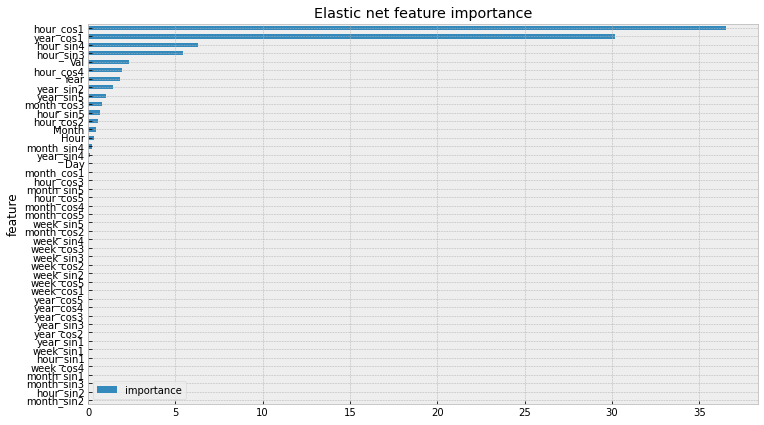

In [80]:
feat_imp = pd.DataFrame({'importance':np.abs(elastic_net_opt_F.coef_)})    
feat_imp['feature'] = X_trainF.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)  
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
_ = feat_imp.plot.barh(title = 'Elastic net feature importance', figsize = (12,7))

### Random Forest Regression

In [81]:
random_grid['max_depth'] = [3,4,5,6,7,8]

In [82]:
random_grid

{'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [3, 4, 5, 6, 7, 8]}

In [83]:
rf = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)

rfF = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               cv = tscv, verbose=2, random_state = 42, n_jobs = -1)


rfF.fit(X_trainF, y_trainF)
rfF.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 94, 'max_features': 'auto', 'max_depth': 6}

In [84]:
rfFourier = RandomForestRegressor(n_estimators= rfF.best_params_['n_estimators'], 
                                  max_features=rfF.best_params_['max_features'], 
                                  max_depth= rfF.best_params_['max_depth'], random_state = 42)
rfFourier.fit(X_trainF, y_trainF)

RandomForestRegressor(max_depth=6, n_estimators=94, random_state=42)

In [85]:
print("Training accuracy R2 using random forest is {}".format(rfF.score(X_trainF, y_trainF)))
print("\nTest accuracy R2 using random forest is {}".format(rfF.score(X_testF, y_testF)))


Training accuracy R2 using random forest is 0.8119797428307519

Test accuracy R2 using random forest is 0.7923784740243012


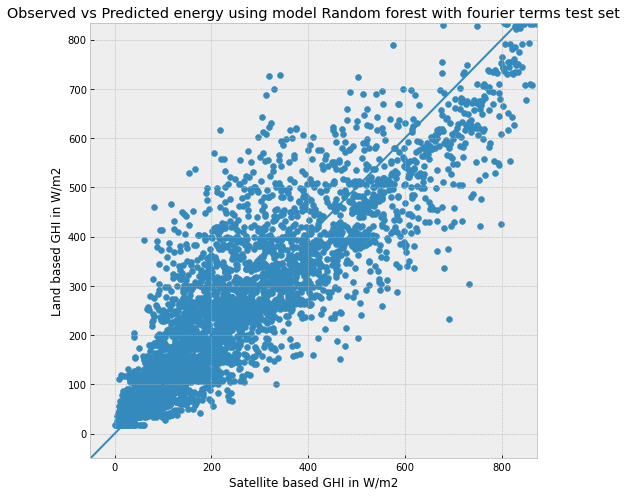

In [86]:
plot_predvstrue_reg(rfF.predict(X_testF), y_testF, model_name='Random forest with fourier terms test set')

In [87]:
print('Random forest errors with fourier terms on training')
error_metrics(rfF.predict(X_trainF), y_trainF, model_name = 'Tuned Random forest with fourier terms', test=False)
print('\nRandom forest errors with fourier terms on test')
error_metrics(rfF.predict(X_testF), y_testF, model_name = 'Tuned Random forest with fourier terms', test=True)

Random forest errors with fourier terms on training

Error metrics for model Tuned Random forest with fourier terms
RMSE or Root mean squared error: 84.68
Variance score: 0.81
Mean Absolute Error: 59.98
Mean Absolute Percentage Error: 41.47 %

Random forest errors with fourier terms on test

Error metrics for model Tuned Random forest with fourier terms
RMSE or Root mean squared error: 88.02
Variance score: 0.79
Mean Absolute Error: 61.33
Mean Absolute Percentage Error: 41.51 %


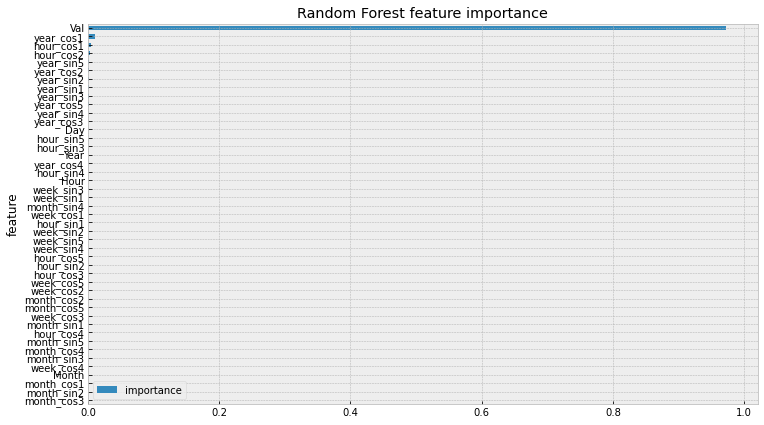

In [88]:
feat_imp = pd.DataFrame({'importance':rfFourier.feature_importances_})    
feat_imp['feature'] = X_trainF.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)   
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
_ = feat_imp.plot.barh(title = 'Random Forest feature importance', figsize = (12,7))

## xgboost

In [89]:
import xgboost as xgb

In [90]:
data_dmatrix = xgb.DMatrix(data = sdgecyc.drop('Tval', axis=1), label = sdgecyc['Tval']) # not used 

In [91]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 3, alpha = 5, n_estimators = 100, random_state=42)

In [92]:
xg_reg.fit(X_trainF, y_trainF)

[02:52:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=42, reg_alpha=5, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [93]:
preds_boost = xg_reg.predict(X_testF)

In [94]:
_ = error_metrics(preds_boost, y_testF, model_name='XGBoost with Fourier terms', test=True)


Error metrics for model XGBoost with Fourier terms
RMSE or Root mean squared error: 90.13
Variance score: 0.78
Mean Absolute Error: 64.99
Mean Absolute Percentage Error: 45.85 %


In [95]:
_ = error_metrics(xg_reg.predict(X_trainF), y_trainF, model_name='XGBoost with Fourier terms', test= False)


Error metrics for model XGBoost with Fourier terms
RMSE or Root mean squared error: 85.68
Variance score: 0.81
Mean Absolute Error: 62.42
Mean Absolute Percentage Error: 42.92 %


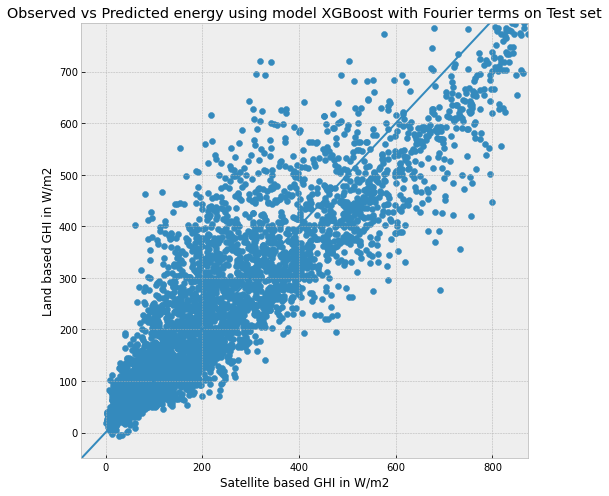

In [96]:
plot_predvstrue_reg(preds_boost,y_testF, model_name='XGBoost with Fourier terms on Test set')

# Max Values

In [97]:
preds_boost_series = pd.Series(preds_boost, index = y_testF.index )

_ = error_metrics(preds_boost_series.resample('24h').max(), 
                  y_testF.resample('24h').max(), 
                  model_name='XGBoost with Fourier terms; daily MAX', test=True)


Error metrics for model XGBoost with Fourier terms; daily MAX
RMSE or Root mean squared error: 99.42
Variance score: 0.80
Mean Absolute Error: 77.20
Mean Absolute Percentage Error: 24.09 %


In [98]:
preds_train = pd.Series(xg_reg.predict(X_trainF), index = y_trainF.index )

_ = error_metrics(preds_train.resample('24h').max(), 
                  y_trainF.resample('24h').max(), 
                  model_name='XGBoost with Fourier terms; daily MAX', test=False)


Error metrics for model XGBoost with Fourier terms; daily MAX
RMSE or Root mean squared error: 97.52
Variance score: 0.82
Mean Absolute Error: 77.30
Mean Absolute Percentage Error: 24.45 %


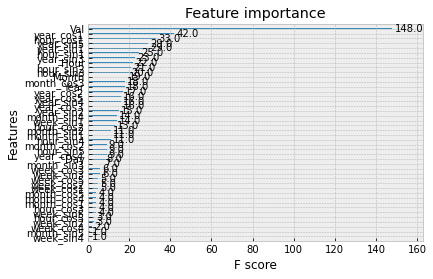

In [99]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 7]

In [100]:
random_grid

{'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [3, 4, 5, 6, 7, 8]}

# Tuning

In [101]:
xgbtuned = xgb.XGBRegressor()

In [102]:
param_grid = {
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200]}

tscv = TimeSeriesSplit(n_splits=3)
xgbtunedreg = RandomizedSearchCV(xgbtuned, param_distributions=param_grid , 
                                   scoring='neg_mean_squared_error', n_iter=20, n_jobs=-1, 
                                   cv=tscv, verbose=2, random_state=42)

xgbtunedreg.fit(X_trainF, y_trainF)
best_score = xgbtunedreg.best_score_
best_params = xgbtunedreg.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best score: -7895.4380959974405
Best params: 
colsample_bylevel: 0.9
colsample_bytree: 0.9
gamma: 1.0
learning_rate: 0.2
max_depth: 4
min_child_weight: 3.0
n_estimators: 31
subsample: 0.9


In [103]:
preds_boost_tuned = xgbtunedreg.predict(X_testF)

In [104]:
_ = error_metrics(preds_boost_tuned, y_testF, model_name='Tuned XGBoost with Fourier terms', test=True)


Error metrics for model Tuned XGBoost with Fourier terms
RMSE or Root mean squared error: 87.51
Variance score: 0.79
Mean Absolute Error: 60.68
Mean Absolute Percentage Error: 43.01 %


In [105]:
_ = error_metrics(xgbtunedreg.predict(X_trainF), y_trainF, model_name='Tuned XGBoost with Fourier terms', test=False)


Error metrics for model Tuned XGBoost with Fourier terms
RMSE or Root mean squared error: 82.38
Variance score: 0.82
Mean Absolute Error: 58.06
Mean Absolute Percentage Error: 39.60 %


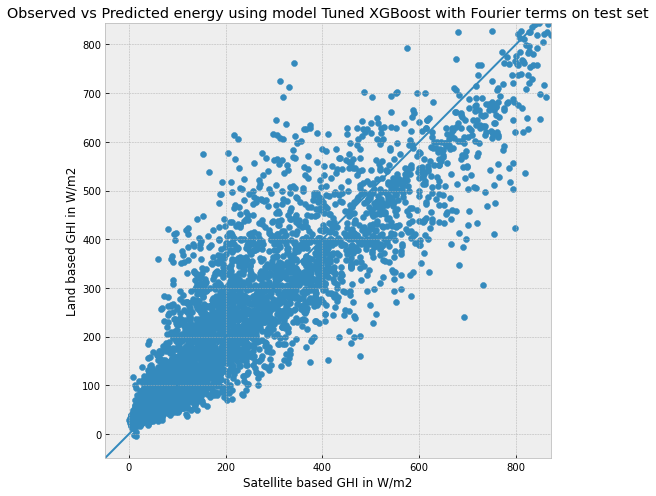

In [106]:
plot_predvstrue_reg(preds_boost_tuned,y_testF, model_name='Tuned XGBoost with Fourier terms on test set')

In [ ]:
stop

# Conclusion

In [107]:
trydf = pd.DataFrame.from_dict(dict_error)
trydf

,model,train_test,RMSE,R2,MAE,MAPE
0,Simple linear regression With Reduced Features,train,87.642798,0.798612,62.115195,39.986547
1,Simple linear regression With Reduced Features,test,89.679660,0.784457,63.660820,38.728317
2,Ridge regression With Reduced Features,train,92.120192,0.777510,68.780618,62.921508
3,Ridge regression With Reduced Features,test,91.558699,0.775330,66.052872,58.731855
4,Tuned elastic net regression With Reduced Feat...,train,89.984976,0.787704,63.704029,45.667253
5,Tuned elastic net regression With Reduced Feat...,test,90.912093,0.778492,63.014664,44.421133
6,Tuned Random forest With Reduced Features,train,88.983603,0.792403,63.111019,46.464379
7,Tuned Random forest With Reduced Features,test,90.418871,0.780889,62.753896,44.942527
8,Elastic net with all lags,train,64.963217,0.889344,46.452304,44.081964
9,Elastic net with all lags,test,61.478287,0.898727,43.991884,46.975946


In [109]:
trydf.pivot_table(index = 'model', columns = 'train_test').sort_values(('R2', 'test'), ascending=True)

MAE             \
train_test                                               test      train   
model                                                                      
Ridge regression With fouriers                      67.878203  67.783406   
Ridge regression With Reduced Features              66.052872  68.780618   
Tuned elastic net regression With Reduced Features  63.014664  63.704029   
Tuned Random forest With Reduced Features           62.753896  63.111019   
XGBoost with Fourier terms                          64.988097  62.417163   
Tuned Elastic net with fourier terms                62.645239  62.089487   
Simple linear regression With FT                    62.830573  61.990775   
Simple linear regression With Reduced Features      63.660820  62.115195   
Tuned Random forest with fourier terms              61.329376  59.976804   
Tuned XGBoost with Fourier terms                    60.678544  58.055595   
XGBoost with Fourier terms; daily MAX               77.204253  77.301372   
Ridge regression With lags                          52.592794  53.625738   
Random forest with all lags                         46.151754  48.113073   
XGBoost with lags                                   44.088234  45.232392   
Elastic net with all lags                           43.991884  46.452304   
Simple linear regression With lags                  43.894697  46.387239   

                                                         MAPE             \
train_test                                               test      train   
model                                                                      
Ridge regression With fouriers                      56.507219  52.499085   
Ridge regression With Reduced Features              58.731855  62.921508   
Tuned elastic net regression With Reduced Features  44.421133  45.667253   
Tuned Random forest With Reduced Features           44.942527  46.464379   
XGBoost with Fourier terms                          45.854235  42.922263   
Tuned Elastic net with fourier terms                45.323374  41.038339   
Simple linear regression With FT                    43.508205  39.817102   
Simple linear regression With Reduced Features      38.728317  39.986547   
Tuned Random forest with fourier terms              41.508213  41.470951   
Tuned XGBoost with Fourier terms                    43.005458  39.600446   
XGBoost with Fourier terms; daily MAX               24.085253  24.445137   
Ridge regression With lags                          62.866260  57.411520   
Random forest with all lags                         36.676066  37.615221   
XGBoost with lags                                   36.192068  35.168282   
Elastic net with all lags                           46.975946  44.081964   
Simple linear regression With lags                  46.842827  43.843093   

                                                          R2            \
train_test                                              test     train   
model                                                                    
Ridge regression With fouriers                      0.769607  0.780666   
Ridge regression With Reduced Features              0.775330  0.777510   
Tuned elastic net regression With Reduced Features  0.778492  0.787704   
Tuned Random forest With Reduced Features           0.780889  0.792403   
XGBoost with Fourier terms                          0.782291  0.807530   
Tuned Elastic net with fourier terms                0.783267  0.797332   
Simple linear regression With FT                    0.783544  0.799692   
Simple linear regression With Reduced Features      0.784457  0.798612   
Tuned Random forest with fourier terms              0.792378  0.811980   
Tuned XGBoost with Fourier terms                    0.794776  0.822076   
XGBoost with Fourier terms; daily MAX               0.802250  0.819895   
Ridge regression With lags                          0.871296  0.866282   
Random forest with all lags                         0.8885

In [110]:
trydf = pd.DataFrame.from_dict(dict_error)
sorted_errors = trydf.pivot_table(index = 'model', columns = 'train_test', 
                                  aggfunc='min').sort_values(('R2', 'test'), ascending=True)

In [111]:
sorted_errors = sorted_errors.drop('MAPE',axis=1)
sorted_errors = sorted_errors.sort_values(('R2','test'),ascending=False)

names = sorted_errors.index.to_list()

In [120]:
sorted_errors

MAE             \
train_test                                               test      train   
model                                                                      
Simple linear regression With lags                  43.894697  46.387239   
Elastic net with all lags                           43.991884  46.452304   
XGBoost with lags                                   44.088234  45.232392   
Random forest with all lags                         46.151754  48.113073   
Ridge regression With lags                          52.592794  53.625738   
XGBoost with Fourier terms; daily MAX               77.204253  77.301372   
Tuned XGBoost with Fourier terms                    60.678544  58.055595   
Tuned Random forest with fourier terms              61.329376  59.976804   
Simple linear regression With Reduced Features      63.660820  62.115195   
Simple linear regression With FT                    62.830573  61.990775   
Tuned Elastic net with fourier terms                62.645239  62.089487   
XGBoost with Fourier terms                          64.988097  62.417163   
Tuned Random forest With Reduced Features           62.753896  63.111019   
Tuned elastic net regression With Reduced Features  63.014664  63.704029   
Ridge regression With Reduced Features              66.052872  68.780618   
Ridge regression With fouriers                      67.878203  67.783406   

                                                          R2            \
train_test                                              test     train   
model                                                                    
Simple linear regression With lags                  0.898986  0.889384   
Elastic net with all lags                           0.898727  0.889344   
XGBoost with lags                                   0.895766  0.893433   
Random forest with all lags                         0.888503  0.882244   
Ridge regression With lags                          0.871296  0.866282   
XGBoost with Fourier terms; daily MAX               0.802250  0.819895   
Tuned XGBoost with Fourier terms                    0.794776  0.822076   
Tuned Random forest with fourier terms              0.792378  0.811980   
Simple linear regression With Reduced Features      0.784457  0.798612   
Simple linear regression With FT                    0.783544  0.799692   
Tuned Elastic net with fourier terms                0.783267  0.797332   
XGBoost with Fourier terms                          0.782291  0.807530   
Tuned Random forest With Reduced Features           0.780889  0.792403   
Tuned elastic net regression With Reduced Features  0.778492  0.787704   
Ridge regression With Reduced Features              0.775330  0.777510   
Ridge regression With fouriers                      0.769607  0.780666   

                                                         RMSE             
train_test                                               test      train  
model                                                                     
Simple linear regression With lags                  61.399585  64.951388  
Elastic net with all lags                           61.478287  64.963217  
XGBoost with lags                                   62.370573  63.751592  
Random forest with all lags                         64.506962  67.015053  
Ridge regression With lags                          69.306176  71.412517  
XGBoost with Fourier terms; daily MAX               99.421644  97.517392  
Tuned XGBoost with Fourier terms                    87.506684  82.379023  
Tuned Random forest with fourier terms              88.016376  84.684073  
Simple linear regression With Reduced Features      89.679660  87.642798  
Simple linear regression With FT                    89.869403  87.407546  
Tuned Elastic net with fourier terms                89.926956  87.920942  
XGBoost with Fourier terms                          90.129175  85.680362  
Tuned Random forest With Reduced Features           90.418871  88.983603  
Tuned 

In [121]:
sorted_errors.shape

(16, 6)

In [113]:
for j in range(len(names)):

    a = names[j]
    x = str(a)
    for i in sorted_errors.iloc[j].values:
        y = round(i,3)
        y = str(y)
        #print(y)
        x +=  ' & ' + y

    x += ' \\\ '
    
    print(x)

Simple linear regression With lags & 43.895 & 46.387 & 0.899 & 0.889 & 61.4 & 64.951 \\ 
Elastic net with all lags & 43.992 & 46.452 & 0.899 & 0.889 & 61.478 & 64.963 \\ 
XGBoost with lags & 44.088 & 45.232 & 0.896 & 0.893 & 62.371 & 63.752 \\ 
Random forest with all lags & 46.152 & 48.113 & 0.889 & 0.882 & 64.507 & 67.015 \\ 
Ridge regression With lags & 52.593 & 53.626 & 0.871 & 0.866 & 69.306 & 71.413 \\ 
XGBoost with Fourier terms; daily MAX & 77.204 & 77.301 & 0.802 & 0.82 & 99.422 & 97.517 \\ 
Tuned XGBoost with Fourier terms & 60.679 & 58.056 & 0.795 & 0.822 & 87.507 & 82.379 \\ 
Tuned Random forest with fourier terms & 61.329 & 59.977 & 0.792 & 0.812 & 88.016 & 84.684 \\ 
Simple linear regression With Reduced Features & 63.661 & 62.115 & 0.784 & 0.799 & 89.68 & 87.643 \\ 
Simple linear regression With FT & 62.831 & 61.991 & 0.784 & 0.8 & 89.869 & 87.408 \\ 
Tuned Elastic net with fourier terms & 62.645 & 62.089 & 0.783 & 0.797 & 89.927 & 87.921 \\ 
XGBoost with Fourier terms & 

In [114]:
table = (sorted_errors.sort_index(axis=1, level=1, ascending=False).sort_index(axis=1, level=[0], sort_remaining=False)).\
round(3)
table.style.highlight_min(['MAPE', 'MAE', 'RMSE'], 
                                  axis=0).highlight_max(['R2'], axis=0).highlight_null(null_color='gray')